# 環境構築とデータの準備

In [1]:
# ライブラリのインポート
from glob import glob

import numpy as np

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [2]:
%%capture
!if [ ! -d train ]; then curl -L -O https://github.com/mitmul/chainer-handson/releases/download/SegmentationDataset/train.zip && unzip train.zip && rm -rf train.zip; fi
!if [ ! -d val ]; then curl -L -O https://github.com/mitmul/chainer-handson/releases/download/SegmentationDataset/val.zip && unzip val.zip && rm -rf val.zip; fi

# データセットに対する前処理

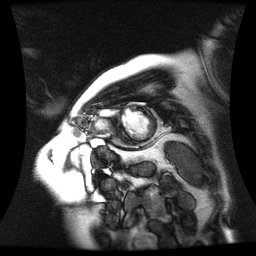

In [3]:
# 入力画像の読み込み
image = Image.open('train/image/000.png')
image

In [4]:
# 画像のタイプ
type(image)

PIL.PngImagePlugin.PngImageFile

In [5]:
# 入力画像に対する前処理を定義
transform = transforms.Compose([
    transforms.ToTensor()  # 最小値 0, 最大値 1 の Tensor 型に変換 (PIL -> NumPy -> Tensor -> min-max normalization -> ch)
])

In [6]:
# 入力画像の定義した前処理を施す
image = transform(image)
image

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [7]:
# shapeの確認
image.shape

torch.Size([1, 256, 256])

In [8]:
# 前処理後の画像タイプ
type(image)

torch.Tensor

In [9]:
# データ型の確認
image.dtype

torch.float32

In [10]:
# 入力画像を前処理後の一意な値のリストを確認
image.unique()

tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314,
        0.0353, 0.0392, 0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667,
        0.0706, 0.0745, 0.0784, 0.0824, 0.0863, 0.0902, 0.0941, 0.0980, 0.1020,
        0.1059, 0.1098, 0.1137, 0.1176, 0.1216, 0.1255, 0.1294, 0.1333, 0.1373,
        0.1412, 0.1451, 0.1490, 0.1529, 0.1569, 0.1608, 0.1647, 0.1686, 0.1725,
        0.1765, 0.1804, 0.1843, 0.1882, 0.1922, 0.1961, 0.2000, 0.2039, 0.2078,
        0.2118, 0.2157, 0.2196, 0.2235, 0.2275, 0.2314, 0.2353, 0.2392, 0.2431,
        0.2471, 0.2510, 0.2549, 0.2588, 0.2627, 0.2667, 0.2706, 0.2745, 0.2784,
        0.2824, 0.2863, 0.2902, 0.2941, 0.2980, 0.3020, 0.3059, 0.3098, 0.3137,
        0.3176, 0.3216, 0.3255, 0.3294, 0.3333, 0.3373, 0.3412, 0.3451, 0.3490,
        0.3529, 0.3569, 0.3608, 0.3647, 0.3686, 0.3725, 0.3765, 0.3804, 0.3843,
        0.3882, 0.3922, 0.3961, 0.4000, 0.4039, 0.4078, 0.4118, 0.4157, 0.4196,
        0.4235, 0.4275, 0.4314, 0.4353, 

In [11]:
# ラベル画像の定義した前処理を施す
label = Image.open('train/label/000.png')

In [12]:
# ndarray型に変換
label = np.array(label)
label

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [13]:
# Tensor型に変換
label = torch.tensor(label, dtype=torch.float32) # ロジスティック回帰と同様0 or 1の二値分類で考えるためtは実数値を取れるようにfloat32
label

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [14]:
# データ型の確認
label.dtype

torch.float32

# Dataset クラスの定義

In [15]:
class MRIDataset(torch.utils.data.Dataset):

    def __init__(self, mode='train'):
        self.images = sorted(glob(f'{mode}/image/*.png'))
        self.labels = sorted(glob(f'{mode}/label/*.png'))
        self.transform = transforms.Compose([ transforms.ToTensor() ])


    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)
        image = self.transform(image)

        label_path = self.labels[idx]
        label = Image.open(label_path)
        label = np.array(label)
        label = torch.tensor(label, dtype=torch.float32)
        return image, label


    def __len__(self):
        return len(self.images)

In [16]:
train = MRIDataset(mode='train')
val = MRIDataset(mode='val')

In [17]:
len(train), len(val)

(234, 26)

In [18]:
x, t = train[0] # x: image, t: label

In [19]:
# imageのshape
x.shape

torch.Size([1, 256, 256])

In [20]:
# labelのshape
t.shape

torch.Size([256, 256])